<a href="https://colab.research.google.com/github/AnandKhandekar/Sub-Pixel-edge-detection/blob/master/sub_pixel_edge_edge%2BVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

#from keras.applications.vgg16 import VGG16


Using TensorFlow backend.


In [0]:
# Upload data file
from google.colab import files
uploaded = files.upload()

In [0]:
# Unzip 'datadir.zip'. Train and Test images are in 'traindir' and 'testdir' respectively
# Displays number of train and test images 
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['datadir.zip']), 'r')
data.extractall()
trainimagesdir = os.path.join('/content/datadir/traindir')
testimagesdir=os.path.join('/content/datadir/testdir')
print('total number of training images:', len(os.listdir(trainimagesdir)))
m=len(os.listdir(trainimagesdir))
print('total number of testinging images:', len(os.listdir(testimagesdir)))
n=len(os.listdir(testimagesdir))
print(m,n)

In [0]:
# Read train images, Convert to grayscale, Downsample by factor 4(as per paper),
# but here directly resized to 512x612, 
from google.colab.patches import cv2_imshow
cv_img=[]
for i in range(m):
  img=cv2.imread('/content/datadir/traindir/img'+str(i+1)+'.jpg')
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  resized_img = cv2.resize(img, (612,512))
  cv_img.append(resized_img)
  cv2.imwrite('/content/datadir/traindir/img'+str(i+1)+'.jpg', img)
print(len(cv_img))
cv_90rows=[]
for i in range(0,len(cv_img)):
  im=np.asarray(cv_img[i])
  count=0
  x=np.array([])
  for j in range(0,512,5):
    if (count<=89):
      x=np.concatenate((x,im[j,:]),axis=0)
      count=count+1
  x=x.reshape(90,612)
  print(x.shape)
  cv_90rows.append(x)
print(len(cv_90rows))

In [0]:
# converting 90x612 sized image into 90 individual vectors
# This step may not require when input is given to 1D-CNN
directory='newtraindir'
parentdir='/content/datadir/'
mypath=os.path.join(parentdir,directory)
os.mkdir(mypath)
directory1='newtestdir'
parentdir1='/content/datadir/'
mypath1=os.path.join(parentdir1,directory1)
os.mkdir(mypath1)
vectored_img=[]
for img in range(len(cv_90rows)):
  new_img=cv_90rows[img]
  cv2_imshow(new_img)
  vector_img=np.reshape(new_img,(90,1,612))
  vectored_img.append(vector_img)
  print(len(vectored_img))

In [0]:
# Canny Edge detection is done. 
sobel_image=[]
for img in range(len(cv_90rows)):
  new_img=cv_90rows[img]
  new_img=np.uint8(new_img)
  sobely=cv2.Canny(new_img,248,255)
  print(new_img.shape)
  sobel_image.append(sobely)
  print(len(sobel_image))
  cv2_imshow(sobel_image[img])
sobel_img_transpose=[]
for img in range(len(sobel_image)):
  sobel_img_trans=cv2.transpose(sobel_image[img])
  print(sobel_img_trans.shape)
  sobel_img_transpose.append(sobel_img_trans)
print(len(sobel_img_transpose))

In [0]:
#Only thin vertival edges detected by erosion
# Co ordinates of edge in each image are found
eroded_image=[]
list_of_coordinates=[]
kernel=np.ones((1,3),np.uint8)
for img in range(len(sobel_img_transpose)):
  eroded=cv2.erode(sobel_img_transpose[img],kernel)
  eroded_image.append(eroded)
  indices = np.where(eroded ==255)
  coordinates = zip(indices[0], indices[1])
  x=tuple(coordinates)
  cv2_imshow(eroded_image[img])
  print(len(x))
  list_of_coordinates.append(x)
list_of_coordinates1 = [list(y) for y in list_of_coordinates]
print(list_of_coordinates1[0])
print(list_of_coordinates1)

In [0]:
# Co ordinates of edge to be passed as y_train to CNN are calculated
# x co ordinate is selected by finding x value which is repeated maximum number of times. This gives continuous edge
# y co ordinate is selected by finding mean of y values so that thickness will be of single pixel 
import statistics
final_ans = [] # list to be returned
for sub_list in list_of_coordinates1:
    first_el = [] # storing first tuple element 
    second_el = [] # storing second tuple element 

    for item in sub_list:
        a,b = item
        first_el.append(a)
        second_el.append(b)
    
    # for the Q1, used mode from stats library
    # for Q2, used mean from stats library, rounded off to 2 decimal places (remove round function if not needed)
    final_ans.append((statistics.mode(first_el), round(statistics.mean(second_el), 2)))
    # print(statistics.mode(first_el), statistics.mean(second_el))

print(final_ans)

In [0]:
#input_shape = (90,612)

model = Sequential([
                    Conv1D(64,3,activation='relu',input_shape=(612,90),padding='same'),
                    Conv1D(64,3,activation='relu',padding='same'),
                    MaxPooling1D(2,strides=2),
                    Conv1D(128,3,activation='relu',padding='same'),
                    Conv1D(128,3,activation='relu',padding='same'),
                    MaxPooling1D(2,strides=2),
                    Conv1D(256,3,activation='relu',padding='same'),
                    Conv1D(256,3,activation='relu',padding='same'),
                    Conv1D(256,3,activation='relu',padding='same'),
                    MaxPooling1D(1,2),
                    Conv1D(512,3,activation='relu',padding='same'),
                    Conv1D(512,3,activation='relu',padding='same'),
                    Conv1D(512,2,activation='relu',padding='same'),
                    MaxPooling1D(1,2),
                    Conv1D(512,3,activation='relu',padding='same'),
                    Conv1D(512,3,activation='relu',padding='same'),
                    Conv1D(512,2,activation='relu',padding='same'),
                    MaxPooling1D(1,2),
                    Flatten(),
                    Dense(4096,activation='relu'),
                    Dense(4096,activation='relu')
])


In [0]:

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 612, 64)           17344     
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 612, 64)           12352     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 306, 64)           0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 306, 128)          24704     
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 306, 128)          49280     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 153, 128)          0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 153, 256)         

In [0]:
print(len(model.layers))

21


In [0]:
model.layers[20].output

<tf.Tensor 'dense_12/Relu:0' shape=(None, 4096) dtype=float32>

In [0]:
tf.expand_dims(
    model.layers[20].output, axis=0, name=None
)

<tf.Tensor 'ExpandDims_1:0' shape=(1, None, 4096) dtype=float32>

# Summary of FILTER shapes

In [0]:
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv1d_63 (3, 90, 64)
conv1d_64 (3, 64, 64)
conv1d_65 (3, 64, 128)
conv1d_66 (3, 128, 128)
conv1d_67 (3, 128, 256)
conv1d_68 (3, 256, 256)
conv1d_69 (3, 256, 256)
conv1d_70 (3, 256, 512)
conv1d_71 (3, 512, 512)
conv1d_72 (2, 512, 512)
conv1d_73 (3, 512, 512)
conv1d_74 (3, 512, 512)
conv1d_75 (2, 512, 512)


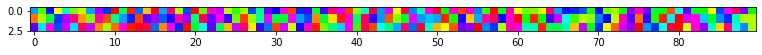

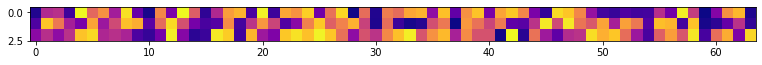

In [0]:
 top_layer = model.layers[0]
top_layer1=model.layers[1]
fig = plt.figure(figsize=(13,5))
plt.imshow(top_layer.get_weights()[0][:, :,0 ].squeeze(), cmap='hsv')
fig = plt.figure(figsize=(13,5))
plt.imshow(top_layer1.get_weights()[0][:, :, 0].squeeze(),cmap='plasma')      
                                                      

# https://keras.io/visualization/

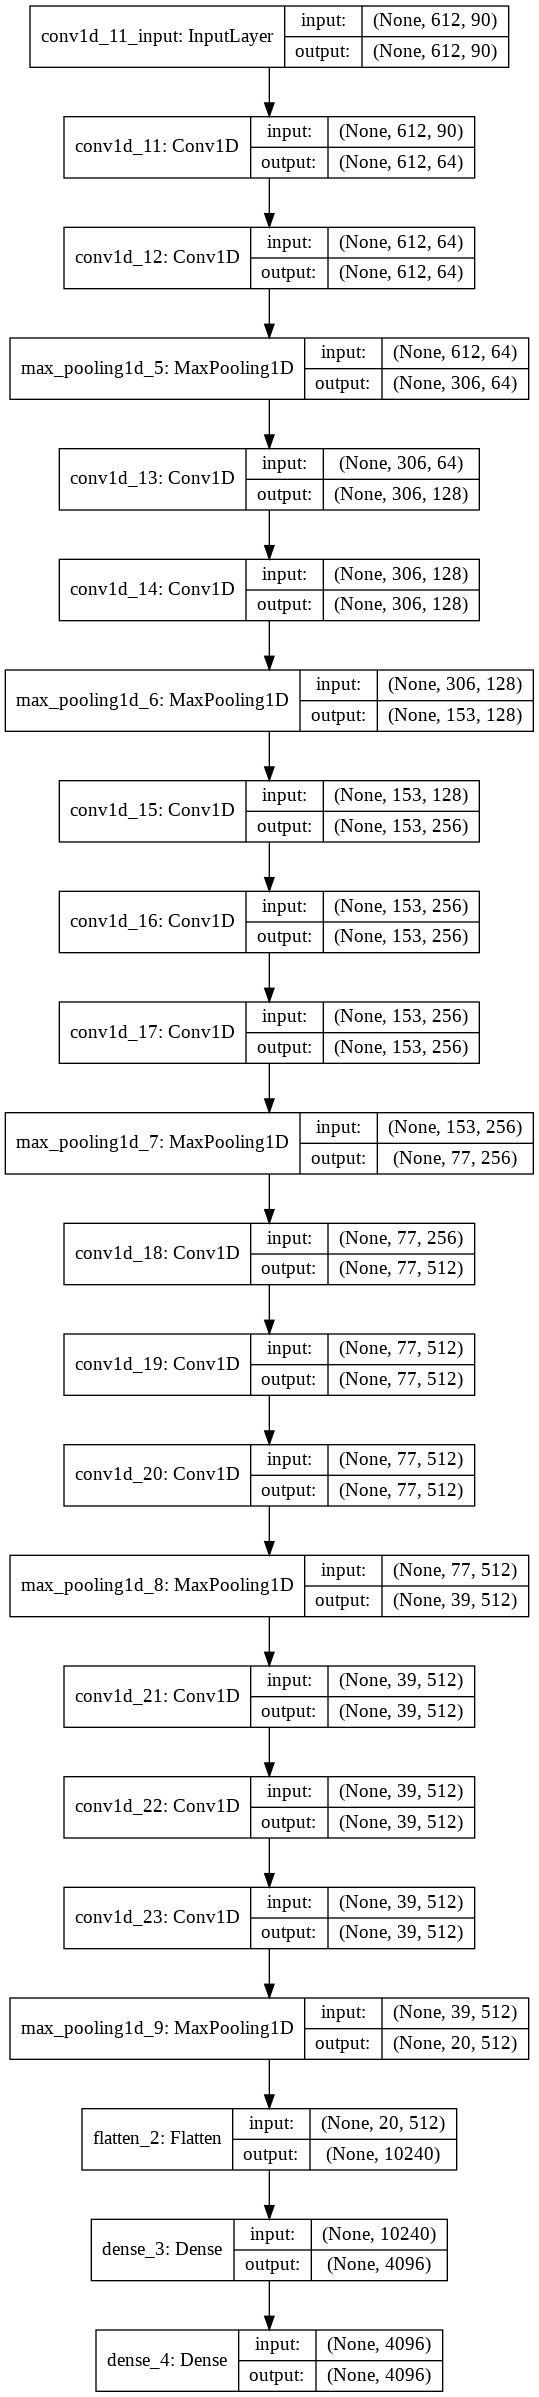

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes= True,expand_nested=True )